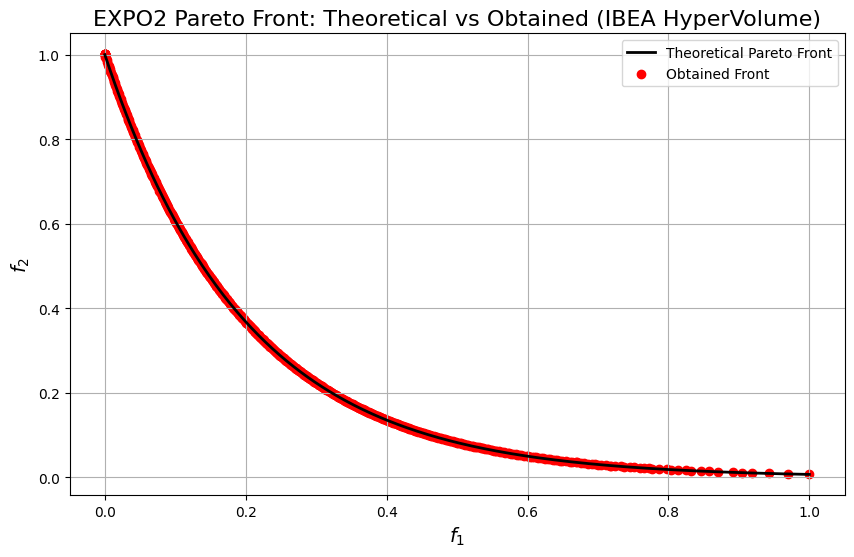

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from pymoors import (
    Ibea,
    RandomSamplingFloat,
    GaussianMutation,
    SimulatedBinaryCrossover,
    CloseDuplicatesCleaner,
    Constraints,
)
from pymoors.schemas import Population
from pymoors.typing import TwoDArray


# ==============================
# EXPO2 — Objective Evaluation
# ==============================
def evaluate_expo2(x: TwoDArray) -> TwoDArray:
    """
    EXPO2 (minimization, 2 objectives).

    g(x) = 1 + (9/(n-1)) * sum_{i=2..n} x_i
    f1(x) = x1
    f2(x) = g(x) * exp( -5 * x1 / g(x) )

    Typical domain: x_i in [0, 1], i=1..n (e.g., n = 30).
    """
    n = x.shape[1]
    if n < 2:
        raise ValueError("EXPO2 requires at least 2 decision variables.")

    # g(x)
    g = 1.0 + (9.0 / (n - 1)) * np.sum(x[:, 1:], axis=1)

    f1 = x[:, 0]
    f2 = g * np.exp(-5.0 * x[:, 0] / g)

    return np.column_stack((f1, f2))


# ==========================================
# Theoretical Front (g=1 => x2..xn = 0; f2=exp(-5 f1))
# ==========================================
def expo2_theoretical_front(num_points: int = 200):
    """
    Returns (f1, f2) arrays of the EXPO2 Pareto front:
        f1 in [0, 1], f2 = exp(-5 f1)
    """
    f1 = np.linspace(0.0, 1.0, num_points)
    f2 = np.exp(-5.0 * f1)
    return f1, f2


# =============================
# Algorithm Setup (IBEA-H)
# =============================
# Problem dimensionality
NUM_VARS = 30

# Hypervolume reference point (minimization ⇒ worse-than-worst)
# We put [6.0, 6.0] far from the normalized range [0,1]
HV_REFERENCE_POINT = np.array([4.0, 4.0], dtype=float)

# kappa controls the selection pressure in IBEA
KAPPA = 0.05


algorithm = Ibea(
    sampler=RandomSamplingFloat(min=0.0, max=1.0),
    crossover=SimulatedBinaryCrossover(distribution_index=15),
    mutation=GaussianMutation(gene_mutation_rate=0.1, sigma=0.1),
    fitness_fn=evaluate_expo2,
    constraints_fn=Constraints(lower_bound=0.0, upper_bound=1.0),
    duplicates_cleaner=CloseDuplicatesCleaner(epsilon=1e-6),
    num_vars=NUM_VARS,
    population_size=600,
    num_offsprings=600,
    num_iterations=600,
    mutation_rate=0.2,
    crossover_rate=0.9,
    keep_infeasible=False,
    reference_points=HV_REFERENCE_POINT,
    kappa=KAPPA,
    verbose=False,
    seed=1,
)

# ===============
# Run IBEA
# ===============
algorithm.run()

# Best front (Population)
best: Population = algorithm.population.best_as_population
obtained = best.fitness  # shape: (num_solutions, 2)

f1_theo, f2_theo = expo2_theoretical_front(num_points=400)
# Plot the theoretical Pareto front, obtained front, and reference points
plt.figure(figsize=(10, 6))
plt.plot(f1_theo, f2_theo, "k-", linewidth=2, label="Theoretical Pareto Front")
plt.scatter(
    obtained[:, 0],
    obtained[:, 1],
    c="r",
    marker="o",
    label="Obtained Front",
)

plt.xlabel("$f_1$", fontsize=14)
plt.ylabel("$f_2$", fontsize=14)
plt.title("EXPO2 Pareto Front: Theoretical vs Obtained (IBEA HyperVolume)", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()